In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

In [3]:
import numpy as np
import numpy.linalg as la
import pandas as pd
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import seaborn as sns

from IPython.display import clear_output
import timeit
from itertools import product

from kernelbiome.kernels_jax import *
from kernelbiome.metrics_jax import *
from kernelbiome.cfi_and_cpd import *
from kernelbiome.utils_cv import *
from kernelbiome.utils_result import *

import warnings
warnings.filterwarnings('always')

/Users/hrt620/.pyenv/versions/3.9.9/envs/kb39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


ModuleNotFoundError: No module named 'weighted_kernels_jax'

In [23]:
from matplotlib import rc
rc('font', **{'family':'tex-gyre-termes', 'size':6.5})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsfonts,amssymb,amsthm,amsmath}')

In [24]:
colors_all = np.vstack([plt.cm.tab20c(range(20)),plt.cm.tab20b(range(20))]) # plt.cm.tab10(range(10)), plt.cm.tab20(range(20)), plt.cm.tab20b(range(20)), 
colors_all = np.unique(colors_all, axis=0)
print(colors_all.shape)

(40, 4)


In [25]:
rng = np.random.default_rng(2022)

In [26]:
p = 3
n = 200
mu = [0,0,0]
# cov = np.eye(3)
cov = [[1, 0.25, -0.25],
       [0.25, 1, 0.25],
       [-0.25, 0.25, 1]]

X = rng.multivariate_normal(mu, cov, n)
X = np.exp(X)
X /= X.sum(axis=1)[:,None]
print(X.shape)

(200, 3)


### Linear model

In [27]:
def true_fun(X):
    return 10*X[:,0] + 10*X[:,1]

CPD and CFI

In [28]:
n_grid = 100
supp_grid = np.zeros((n_grid, p))
for jj in range(p):
    supp_grid[:,jj] = np.linspace(min(X[:,jj]), max(X[:,jj]), num=n_grid)
cpd_vals = get_cfi(X, supp_grid, true_fun, rescale=True, verbose=False)
pdp_vals = get_cfi(X, supp_grid, true_fun, rescale=False, verbose=False)

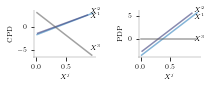

In [29]:
fig, axs = plt.subplots(1,2,figsize=(12, 6), gridspec_kw={'width_ratios': [1,1]})
plot_cfi(supp_grid, cpd_vals, labels=[f'$X^{jj+1}$' for jj in range(X.shape[1])], colors=colors_all[::2], axs=axs[0])
plot_cfi(supp_grid, pdp_vals, labels=[f'$X^{jj+1}$' for jj in range(X.shape[1])], colors=colors_all[::2], axs=axs[1], ylable='PDP')
axs[0].annotate(r'$X^2$', (0.9, 3))
axs[0].annotate(r'$X^1$', (0.9, 2))
axs[0].annotate(r'$X^3$', (0.9, -5))
axs[1].annotate(r'$X^2$', (0.9, 6))
axs[1].annotate(r'$X^1$', (0.9, 4.5))
axs[1].annotate(r'$X^3$', (0.9, -0.5))
# axs[1].legend(loc='best', bbox_to_anchor=(1, 0.75, 0.2, 0.2))
fig.set_size_inches(3, 1.2)
fig.tight_layout()
fig.savefig("example_f1_cpd_vs_pdp_lm.pdf", bbox_inches='tight')
plt.show()

CFI v.s. CFI (no projection) v.s. PI

In [30]:
df = num_df_mat(true_fun, 1e-5, X)
cfi_index_vals = get_perturbation_cfi_index(X, df)
cfi_index_vals

array([ 0.84649862,  0.87407802, -1.72057664])

In [31]:
df = num_df_mat(true_fun, 1e-5, X)
cfi_index_vals = get_perturbation_cfi_index(X, df, proj=False)
cfi_index_vals

array([3.76070319, 2.98653789, 0.        ])

In [32]:
from sklearn.metrics import mean_squared_error

B = 30
perm_imp = np.zeros(3)
baseline_mse = 0
for jj in range(3):
    for ii in range(B):
        X_loc = X.copy()
        rng.shuffle(X_loc[:,jj])
        y_loc = true_fun(X_loc)
        perm_imp[jj] += mean_squared_error(true_fun(X), y_loc) - baseline_mse
perm_imp /= B
perm_imp

array([11.32687568,  5.8737949 ,  0.        ])

### Non-linear ratio model

In [33]:
def true_fun(X):
    """
    f(x) = (1-x^2-x^3)/(1-x^3)
    """
    return 10*(1-X[:,1]-X[:,2])/(1-X[:,2])
    # return 10*(X[:,0])/(X[:,0]+X[:,1])

CPD v.s. PDP

In [34]:
n_grid = 100
supp_grid = np.zeros((n_grid, p))
for jj in range(p):
    supp_grid[:,jj] = np.linspace(min(X[:,jj]), max(X[:,jj]), num=n_grid)
cpd_vals = get_cfi(X, supp_grid, true_fun, rescale=True, verbose=False)
pdp_vals = get_cfi(X, supp_grid, true_fun, rescale=False, verbose=False)

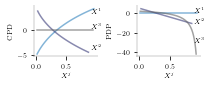

In [35]:
fig, axs = plt.subplots(1,2,figsize=(12, 6), gridspec_kw={'width_ratios': [1,1]})
plot_cfi(supp_grid, cpd_vals, labels=[f'$X^{jj+1}$' for jj in range(X.shape[1])], colors=colors_all[::2], axs=axs[0])
plot_cfi(supp_grid, pdp_vals, labels=[f'$X^{jj+1}$' for jj in range(X.shape[1])], colors=colors_all[::2], axs=axs[1], ylable='PDP')
# axs[1].legend(loc='best', bbox_to_anchor=(1, 0.75, 0.2, 0.2))
axs[0].annotate(r'$X^1$', (0.9, 3.5))
axs[0].annotate(r'$X^3$', (0.9, 0.5))
axs[0].annotate(r'$X^2$', (0.9, -4))
axs[1].annotate(r'$X^1$', (0.9, 0.5))
axs[1].annotate(r'$X^2$', (0.9, -10))
axs[1].annotate(r'$X^3$', (0.9, -30))
fig.set_size_inches(3, 1.2)
fig.tight_layout()
fig.savefig("example_f2_cpd_vs_pdp_nlm.pdf", bbox_inches='tight')
plt.show()

CFI v.s. CFI (no projection) v.s. PI

In [36]:
df = num_df_mat(true_fun, 1e-5, X)
cfi_index_vals = get_perturbation_cfi_index(X, df)
cfi_index_vals

array([ 1.94163733e+00, -1.94163733e+00, -4.61482565e-10])

In [37]:
df = num_df_mat(true_fun, 1e-5, X)
cfi_index_vals = get_perturbation_cfi_index(X, df, proj=False)
cfi_index_vals

array([ 0.        , -4.71575039, -4.40021705])

In [38]:
from sklearn.metrics import mean_squared_error

B = 30
perm_imp = np.zeros(3)
baseline_mse = 0
for jj in range(3):
    for ii in range(B):
        X_loc = X.copy()
        rng.shuffle(X_loc[:,jj])
        y_loc = true_fun(X_loc)
        perm_imp[jj] += mean_squared_error(true_fun(X), y_loc) - baseline_mse
perm_imp /= B
perm_imp


array([ 0.        , 34.89888577, 25.39415958])